# MECANISMO BIELA-MANIVELA INVERTIDA

## ANIMACIÓN

In [1]:
import numpy as np
import math as math
import array as arr
import pprint  # para depurar
import matplotlib.pyplot as plt  #Para graficas
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
#%matplotlib inline (Para notebook)



print ('BIELA-MANIVELA INVERTIDA')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["L3"] = float (input ('Introduce longitud L3: '))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["beta"] = float (input ('Introduce angulo inicial beta: '))
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["YB"] = float (input ('Introduce coordenada en y del punto B:'))
meca["XA"] = 0
meca["YA"] = 0

# Defino posicion inicial:
q = np.array ([[0.1], [0.2], [1], [0.2], [meca["XB"]+meca["L3"]*math.cos(meca["beta"])], [meca["YB"]+meca["L3"]*math.sin(meca["beta"])], [meca["theta"]], [meca["beta"]]])
print('q: ' + str(q))

# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((8,8))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,4] = -2*(meca["XB"]-X3)
    Jacob[2,5] = -2*(meca["YB"]-Y3)
    Jacob[3,0] = -(Y2-Y1) + (Y3-Y1)
    Jacob[3,1] = (X2-X1) - (X3-X1)
    Jacob[3,2] = -(Y3-Y1)
    Jacob[3,3] = X3-X1
    Jacob[3,4] = (Y2-Y1)
    Jacob[3,5] = -(X2-X1)
	
    if (abs(math.cos(theta)) < 0.95 ):
        Jacob[4,6] = meca["L1"]*math.sin(theta)
        Jacob[4,0] = 1
    else:
        Jacob[4,6] = -meca["L1"]*math.cos(theta)
        Jacob[4,1] = 1


    if (abs(math.cos(beta)) < 0.95 ):
        Jacob[5,7] = meca["L3"]*math.sin(beta)
        Jacob[5,4] = 1
    else:
        Jacob[5,7] = -meca["L3"]*math.cos(beta)
        Jacob[5,5] = 1
		

    Jacob[6,6] = 1
    Jacob[7,7] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((8,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]

						
    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 - meca["L2"]**2
    Phi[2] = (meca["XB"]-X3)**2 + (meca["YB"]-Y3)**2 - meca["L3"]**2
    Phi[3] = (X3-X1)*(Y2-Y1) - (X2-X1)*(Y3-Y1)
     
    if (abs(math.cos(theta)) < 0.95):
        Phi[4] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[4] = Y1-meca["L1"]*math.sin(theta)
		

    if (abs(math.cos(beta)) < 0.95):
        Phi[5] = (X3-meca["XB"])-meca["L3"]*math.cos(beta)
    else: 
        Phi[5] = (Y3-meca["YB"])-meca["L3"]*math.sin(beta)


    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((8,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):
        #print("q=")
        #pprint.pprint(q)


        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        X3 = q[4]
        Y3 = q[5]
        theta = q[6]
        beta = q[7]
       
        fi=Phi(q,meca)

        J = jacob_Phiq(q,meca)
    
        rango = np.linalg.matrix_rank(J, 1e-5)
        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1

    return q

q = resuelve_prob_posicion(q,meca)

def dibuja_mecanismo(q, meca):


    # Extraer los puntos moviles del mecanismo
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]
    
	
    plt.axis('equal')
    
    
    plt.plot ([meca["XA"], X1], [meca["YA"], Y1])    #[pos inicial (x1,x2), pos final (y1,y2)]
    plt.plot ([X1, X2], [Y1, Y2])  
    plt.plot ([X3, meca["XB"]], [Y3, meca ["YB"]])  
	
    plt.plot(meca["XA"], meca["YA"], 'bo') 
    plt.plot(meca["XB"], meca["YB"], 'go') 
	
    plt.show()#block=False) 
    return


BIELA-MANIVELA INVERTIDA
Introduce longitud L1:2
Introduce longitud L2:3
Introduce longitud L3: 1
Introduce angulo inicial theta:0
Introduce angulo inicial beta: 0
Introduce coordenada en x del punto B:2
Introduce coordenada en y del punto B:0
q: [[0.1]
 [0.2]
 [1. ]
 [0.2]
 [3. ]
 [0. ]
 [0. ]
 [0. ]]


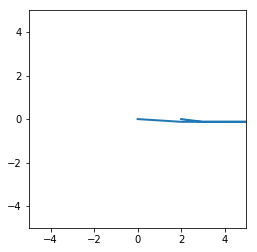

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()

ax.set_xlim(( -5, 5))
ax.set_ylim((-5,5))
ax.set_aspect('equal')

line, = ax.plot([], [], lw=2)

last_q = q

def init():
    line.set_data([], [])
    return (line,)

def animate(i,q,meca):
    global last_q
    q = last_q
    # i: contador de iteracion: hay que mapearla a un ángulo de la manivela
    omega=2*3.14159/100  # vel. angular
    q[6] = i*omega
    q[7] = 2*i*omega
    
    #llamar problema de pos:    
    q = resuelve_prob_posicion(q, meca)
    last_q = q
     
    #Extraer las coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    X3 = q[4]
    Y3 = q[5]
    theta = q[6]
    beta = q[7]
       
    x=[meca["XA"], X1, X2, X3, meca["XB"]]
    y=[meca["YA"], Y1, Y2, Y3, meca["YB"]]
    
    
    line.set_data(x, y)
    return (line,)


anim = animation.FuncAnimation(fig, animate, init_func=init, fargs=(q,meca),
                               frames=100, interval=20, 
                               blit=True)

HTML(anim.to_html5_video())

q
array([[ 2.00000000e+000],
       [ 0.00000000e+000],
       [ 5.00000000e+000],
       [-4.79732144e-174],
       [ 3.00000000e+000],
       [ 0.00000000e+000],
       [ 0.00000000e+000],
       [ 0.00000000e+000]])


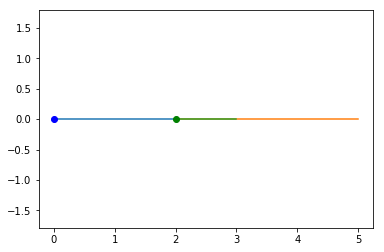

q
array([[ 1.99238941],
       [ 0.17431134],
       [ 4.981145  ],
       [-0.08518818],
       [ 2.9961947 ],
       [ 0.08715567],
       [ 0.08726639],
       [ 0.08726639]])


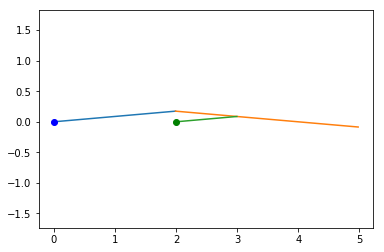

q
array([[ 1.96961556],
       [ 0.34729606],
       [ 4.92666884],
       [-0.15850616],
       [ 2.98480778],
       [ 0.17364803],
       [ 0.17453278],
       [ 0.17453278]])


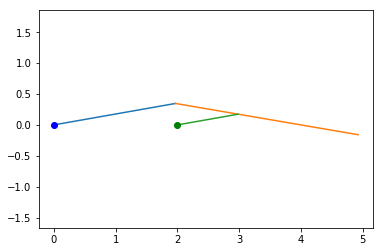

q
array([[ 1.93185177],
       [ 0.51763766],
       [ 4.8420803 ],
       [-0.21076462],
       [ 2.96592588],
       [ 0.25881883],
       [ 0.26179917],
       [ 0.26179917]])


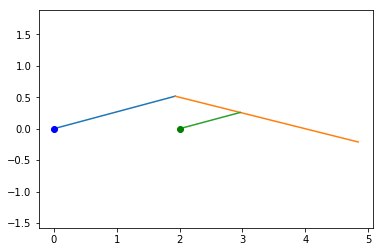

q
array([[ 1.87938544],
       [ 0.68403973],
       [ 4.73452289],
       [-0.23693266],
       [ 2.93969272],
       [ 0.34201987],
       [ 0.34906556],
       [ 0.34906556]])


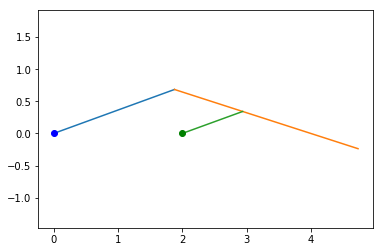

q
array([[ 1.81261589],
       [ 0.84523586],
       [ 4.6109629 ],
       [-0.23608462],
       [ 2.90630794],
       [ 0.42261793],
       [ 0.43633194],
       [ 0.43633194]])


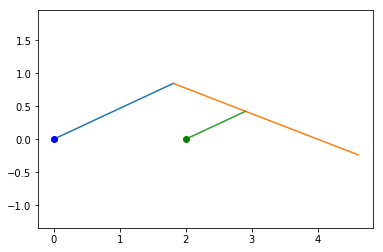

q
array([[ 1.73205125],
       [ 0.99999923],
       [ 4.47705776],
       [-0.21034752],
       [ 2.86602562],
       [ 0.49999962],
       [ 0.52359833],
       [ 0.52359833]])


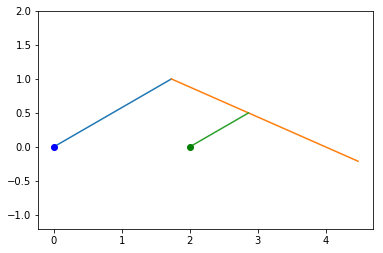

q
array([[ 1.63830468],
       [ 1.14715203],
       [ 4.3368099 ],
       [-0.1635995 ],
       [ 2.81915234],
       [ 0.57357601],
       [ 0.61086472],
       [ 0.61086472]])


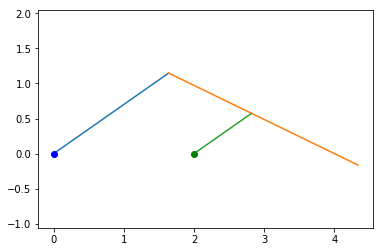

q
array([[ 1.53208964],
       [ 1.28557432],
       [ 4.19274164],
       [-0.10040223],
       [ 2.76604482],
       [ 0.64278716],
       [ 0.69813111],
       [ 0.69813111]])


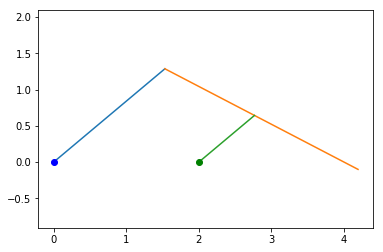

q
array([[ 1.4142145 ],
       [ 1.41421262],
       [ 4.04628028],
       [-0.02531152],
       [ 2.70710725],
       [ 0.70710631],
       [ 0.7853975 ],
       [ 0.7853975 ]])


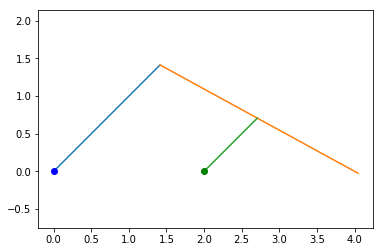

q
array([[1.28557635],
       [1.53208794],
       [3.89815145],
       [0.05748584],
       [2.64278817],
       [0.76604397],
       [0.87266389],
       [0.87266389]])


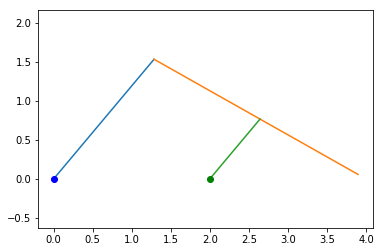

q
array([[1.1471542 ],
       [1.63830316],
       [3.74869362],
       [0.14431766],
       [2.5735771 ],
       [0.81915158],
       [0.95993028],
       [0.95993028]])


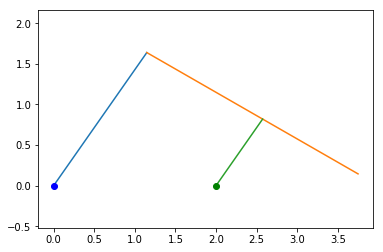

q
array([[1.00000153],
       [1.73204992],
       [3.59807774],
       [0.23204992],
       [2.50000077],
       [0.86602496],
       [1.04719667],
       [1.04719667]])


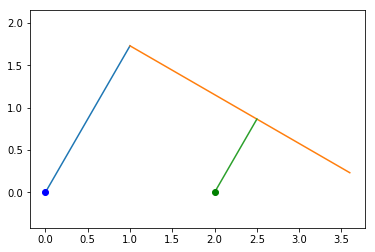

q
array([[0.84523826],
       [1.81261476],
       [3.44644632],
       [0.31805241],
       [2.42261913],
       [0.90630738],
       [1.13446306],
       [1.13446306]])


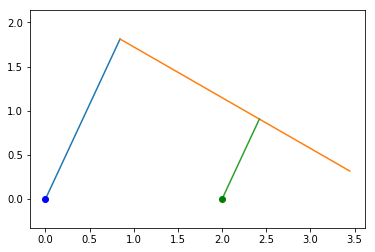

q
array([[0.68404223],
       [1.87938454],
       [3.29399338],
       [0.40014319],
       [2.34202111],
       [0.93969227],
       [1.22172944],
       [1.22172944]])


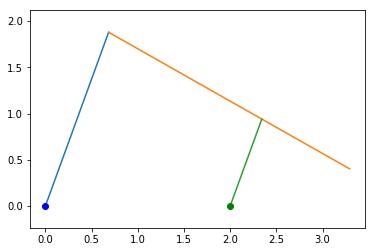

q
array([[0.51764023],
       [1.93185108],
       [3.14100487],
       [0.47653051],
       [2.25882011],
       [0.96592554],
       [1.30899583],
       [1.30899583]])


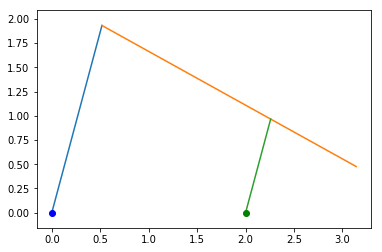

q
array([[0.34729868],
       [1.9696151 ],
       [2.98787384],
       [0.54576019],
       [2.17364934],
       [0.98480755],
       [1.39626222],
       [1.39626222]])


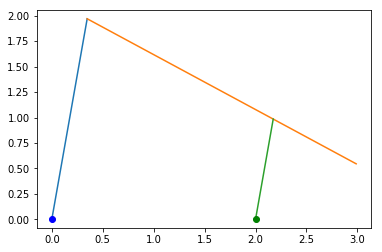

q
array([[0.17431398],
       [1.99238918],
       [2.83510058],
       [0.60667106],
       [2.08715699],
       [0.99619459],
       [1.48352861],
       [1.48352861]])


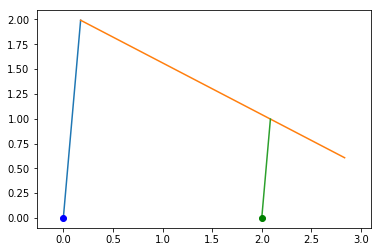

q
array([[2.65358979e-06],
       [2.00000000e+00],
       [2.68328387e+00],
       [6.58358501e-01],
       [2.00000133e+00],
       [1.00000000e+00],
       [1.57079500e+00],
       [1.57079500e+00]])


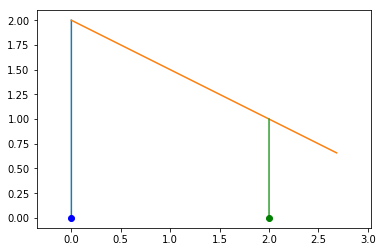

q
array([[-0.1743087 ],
       [ 1.99238964],
       [ 2.53310771],
       [ 0.70014492],
       [ 1.91284565],
       [ 0.99619482],
       [ 1.65806139],
       [ 1.65806139]])


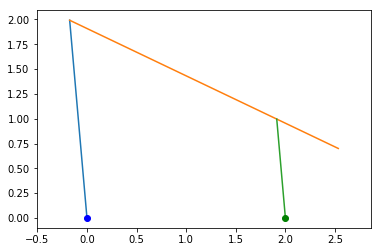

q
array([[-0.34729345],
       [ 1.96961602],
       [ 2.38532567],
       [ 0.73155596],
       [ 1.82635327],
       [ 0.98480801],
       [ 1.74532778],
       [ 1.74532778]])


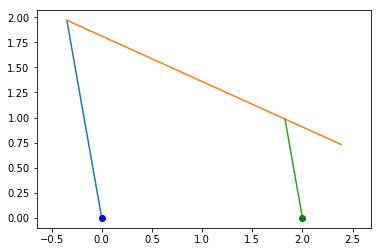

q
array([[-0.5176351 ],
       [ 1.93185245],
       [ 2.24074461],
       [ 0.7523011 ],
       [ 1.74118245],
       [ 0.96592623],
       [ 1.83259417],
       [ 1.83259417]])


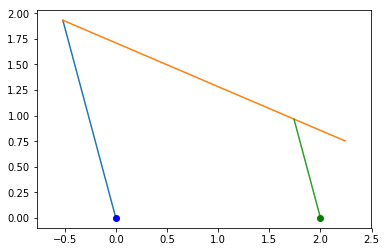

q
array([[-0.68403724],
       [ 1.87938635],
       [ 2.10020829],
       [ 0.76225752],
       [ 1.65798138],
       [ 0.93969318],
       [ 1.91986056],
       [ 1.91986056]])


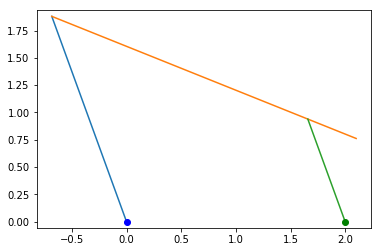

q
array([[-0.84523345],
       [ 1.81261701],
       [ 1.96458172],
       [ 0.76145635],
       [ 1.57738327],
       [ 0.9063085 ],
       [ 2.00712694],
       [ 2.00712694]])


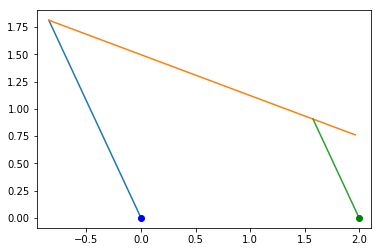

q
array([[-0.99999694],
       [ 1.73205258],
       [ 1.83473612],
       [ 0.75007064],
       [ 1.50000153],
       [ 0.86602629],
       [ 2.09439333],
       [ 2.09439333]])


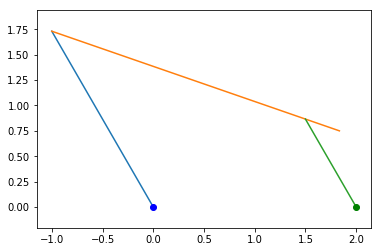

q
array([[-1.14714985],
       [ 1.6383062 ],
       [ 1.71153493],
       [ 0.72840438],
       [ 1.42642507],
       [ 0.8191531 ],
       [ 2.18165972],
       [ 2.18165972]])


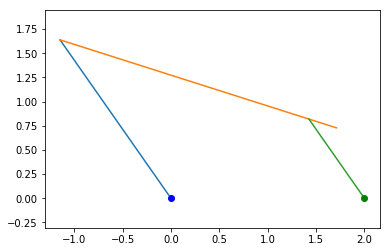

q
array([[-1.28557228],
       [ 1.53209135],
       [ 1.59582078],
       [ 0.69688238],
       [ 1.35721386],
       [ 0.76604568],
       [ 2.26892611],
       [ 2.26892611]])


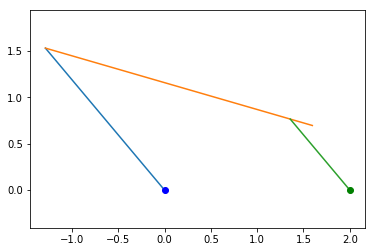

q
array([[-1.41421075],
       [ 1.41421638],
       [ 1.48840345],
       [ 0.6560404 ],
       [ 1.29289463],
       [ 0.70710819],
       [ 2.3561925 ],
       [ 2.3561925 ]])


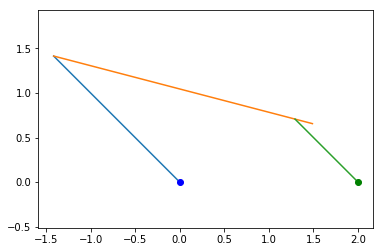

q
array([[-1.53208623],
       [ 1.28557838],
       [ 1.3900489 ],
       [ 0.60651562],
       [ 1.23395688],
       [ 0.64278919],
       [ 2.44345889],
       [ 2.44345889]])


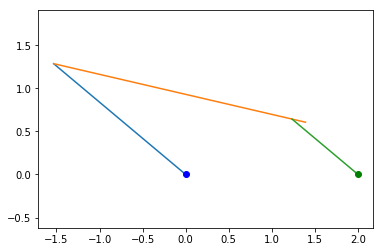

In [ ]:
i = 0

while (i<200):
      
    q[6] = i*5*3.14159/180
    q[7] = i*5*3.14159/180
    q = resuelve_prob_posicion(q,meca)
    print ("q")
    pprint.pprint (q)
    dibuja_mecanismo(q,meca) 
    sleep(0.2)
    i= i+1
	
os.system('pause') 
	